# Computer Vision: Camera Calibration by DLT Algorithm
### Tristan Smith

This is a demonstration of the Direct Linear Transform (DLT) algorithm for recovering the calibration matrix for a camera given an image and some reference points within the scene. It finds a mapping between points in the world and points in the camera's image output, according to a local coordinate system. This and similar techniques have applications in **augmented reality**, **image correction**, **forensic analysis** and more.

In [57]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

We will be recovering (approximately) the calibration matrix for the camera used to take the below image of a blocks puzzle. The calibration matrix contains information like the camera's position, orientation and focal length relative to a coordinate system of our choosing.  

Here, a convenient choice would be to have our coordinates align with the faces of the blocks puzzle, where one cube of the puzzle is one unit of volume in the world. Let's make the bottom corner closest to us the origin. The edges coming out of that point from left to right will be on the X, Y and Z axes respectively.  

Below are 3 pairs of control points. The points must be non co-planar, so they give enough information to recover all degrees of freedom for our camera.

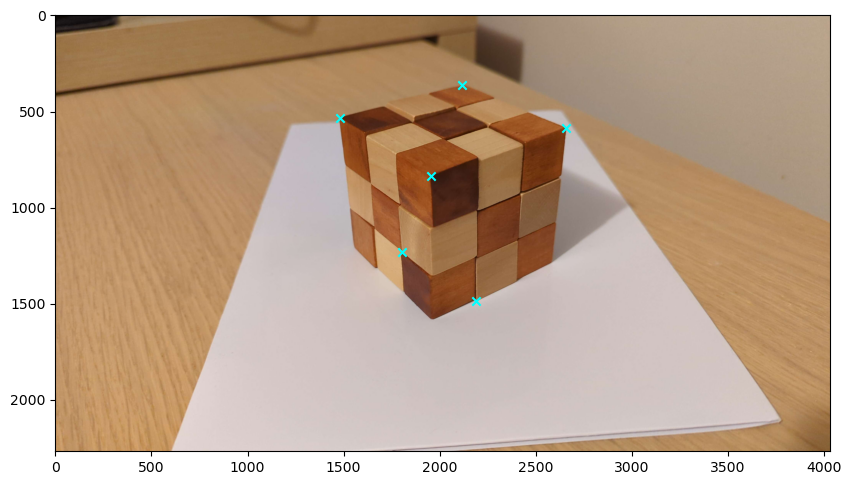

In [58]:
# Load and plot the image and control points
I = Image.open('calib1.jpg');
cpoints_i = np.array([[2190,1488],[2655,588],[1479,534],[1803,1233],[2118,363],[1953,837]])#np.load("calibration_points.npy")
fig_cp = plt.figure(figsize=(10,10))
plt.scatter(cpoints_i[:,0],cpoints_i[:,1],marker="x",color="cyan")
plt.imshow(I)
plt.show()

The following points are block puzzle based world coordinates corresopnding to the image points above. They are scaled by 2.5 because each block is 2.5cm x 2.5cm x 2.5cm, so the scale of our scene can be recovered in cm

In [59]:
cpoints_w = 2.5 * np.array([[0,0,1],[0,3,3],[3,3,0],[1,1,0],[3,3,3],[0,3,0]])

The *calibrate* function below uses a general DLT implementation written in *st_DLT*. \
*st_DLT* computes the DLT for correspondences between 2d to 2d or 3d to 2d points. It creates a 3xN matrix **A_coeff** by concatenating the first 2 rows of the skew symmetric matrix for each of the 2d target points (in homogeneous form), then repeating each element in each row contiguously either 3 or 4 times according to **N**: the dimension of the source points (in homogeneous form). Source points are given as a stack of row vectors. The function contiguously repeats each of these rows twice vertically, and then tiles (interleaved repetition) them horizontally three times to produce another 3x**N** matrix. This and the **A_coeff** matrices are multiplied element-wise to produce the final **A** matrix, representing **A** in the system **Ap = 0** where **p** is the 12x1 vector of projective matrix unknowns. \
\
It finally invokes numpy's built in *linalg.svd* function to compute the singular value decomposition of **A**. The vector corresponding to the lowest singular value is then reshaped and returned as a 3x**N** matrix.

In [60]:
# return the skew symmetric matrix of 3-value vector v
def skew(v):
    x, y, w = v[0], v[1], v[2]
    return np.array([[ 0, -w,  y],
                     [ w,  0, -x],
                     [-y,  x,  0]])

# convert a set of vectors stacked in rows to homogeneous coords
def homogeneous(v):
    return np.pad(v, ((0,0),(0,1)), constant_values=(1))

# compute the DLT transformation matrix between sets of source and target points
# source: stack of source points as rows in homogeneous form
# target: stack of target points as rows in homogeneous form
def st_DLT(source, target):
    # repeat each column of the first 2 rows of the skew symmetric matrix n times
    # for each target point where n is dimension of the source points (in homogeneous form)
    A_coeff = np.concatenate([skew(v)[:2] for v in target]).repeat(source.shape[1], axis=1)
    
    # element-wise product between the target points and each group of n repeated
    # skew symmetric values (done row-wise)
    A = A_coeff * np.tile(source.repeat(2,axis=0), 3)
    
    # get the row of the transpose SVD matrix corresponding to the 
    # smallest singular value
    C = np.linalg.svd(A)[2][-1,:]
    
    return C.reshape(3, source.shape[1])

def calibrate(im, XYZ, uv):
    P = st_DLT(homogeneous(XYZ), homogeneous(uv))
    
    # Ensure the values of P sum to 1
    C = (P / np.sum(P))
    
    # Create a set of reprojected points using C
    test_ps = []
    for wp in homogeneous(XYZ):
        test_p = C @ wp
        test_ps.append((test_p / test_p[-1])[:-1])
    test_ps = np.array(test_ps)

    # Plot the original and reprojected target points superimposed
    fig_test = plt.figure(figsize=(10,10))
    plt.imshow(im)
    plt.scatter(uv[:,0], uv[:,1], marker="x", color="cyan", label="original")
    plt.scatter(test_ps[:,0], test_ps[:,1], marker="+", color="red", label="reconstructed")
    
    # Calculate vectors which lie on the lines to infinity from the world origin
    # As image coordinates
    x_inf, y_inf, z_inf = C @ [100,0,0,1], C @ [0,15,0,1], C @ [0,0,100,1]
    x_inf, y_inf, z_inf = x_inf[:-1]/x_inf[-1], y_inf[:-1]/y_inf[-1], z_inf[:-1]/z_inf[-1]
    
    # Calculate the world origin in image coordinates
    origin =  C @ [0,0,0,1]
    origin = origin[:-1] / origin[-1]
    
    # Plot the lines to infinity from the world origin
    plt.plot(np.linspace(origin[0], x_inf[0]), np.linspace(origin[1], x_inf[1]), label="X")
    plt.plot(np.linspace(origin[0], y_inf[0]), np.linspace(origin[1], y_inf[1]), label="Y")
    plt.plot(np.linspace(origin[0], z_inf[0]), np.linspace(origin[1], z_inf[1]), label="Z")
    plt.xlim(0,np.array(im).shape[1])
    plt.ylim(np.array(im).shape[0],0)
    
    plt.legend()
    plt.show()
    
    # Calculate the average MSE projection error in x and y
    avg_MSE2d = np.mean((uv - test_ps)**2, axis=0)
    print(f"Average Projection Error in x: {avg_MSE2d[0]}")
    print(f"Average Projection Error in y: {avg_MSE2d[1]}\n")
    
    return C

To verify that the calibration matrix has been calcluated correclty, we use it to re-project the control points from world coordinates back to image coordinates. We can also use it to plot axis-aligned lines. It seems that there is some error (the control points are hand picked and the blocks not perfectly aligned), but the result is generally correct.

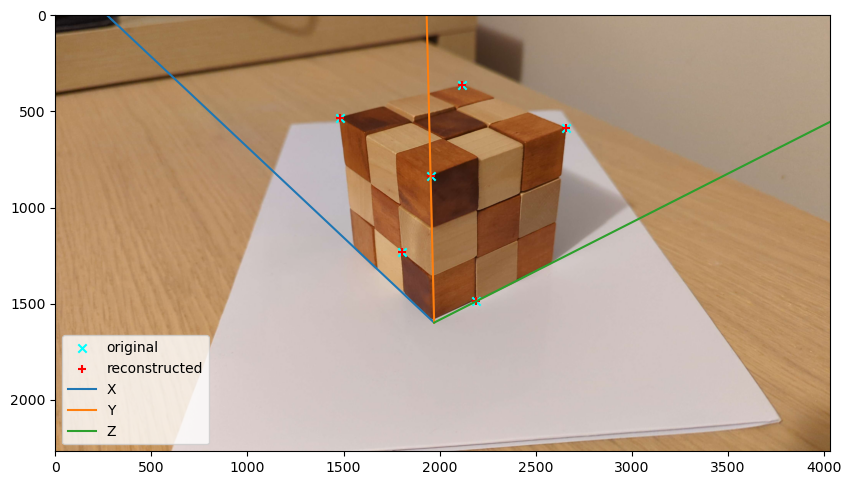

Average Projection Error in x: 0.05521441162084705
Average Projection Error in y: 0.11767089120316358

Camera Calibration Matrix:
[[-3.99515396e-03 -1.23527946e-02  3.66038064e-02  5.65578068e-01]
 [-5.69341825e-03 -3.41368607e-02 -4.93107517e-03  4.58633616e-01]
 [ 7.63610181e-06 -5.96270253e-06  5.24582583e-06  2.86893719e-04]]



In [61]:
C = calibrate(I, cpoints_w, cpoints_i)
print(f"Camera Calibration Matrix:\n{C}\n")